In [1]:
def install_dependencies():
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--no-deps", "xformers", "trl<0.9.0", "peft", "accelerate", "bitsandbytes","sentence-transformers", "mlflow","rouge-score","deprecated","opentelemetry-sdk","opentelemetry-api","opentelemetry-semantic-conventions"])

def load_packages():
    global mlflow, pd, Dataset, train_test_split, torch, plt, rouge_scorer, SentenceTransformer, util
    global FastLanguageModel, is_bfloat16_supported, SFTTrainer, TrainingArguments

    try:
        import mlflow
        # import mlflow.pyfunc
        # import mlflow.pytorch
        # from mlflow.models.signature import infer_signature
        import pandas as pd
        from datasets import Dataset
        from sklearn.model_selection import train_test_split
        import torch
        import matplotlib.pyplot as plt
        from rouge_score import rouge_scorer
        from sentence_transformers import SentenceTransformer
        from sentence_transformers import util
        from unsloth import FastLanguageModel
        from unsloth import is_bfloat16_supported
        from trl import SFTTrainer
        from transformers import TrainingArguments
        from opentelemetry import trace
        from opentelemetry.context import Context
        from opentelemetry.sdk.trace import TracerProvider
        from opentelemetry.sdk.trace.export import SimpleSpanProcessor, ConsoleSpanExporter
    except ModuleNotFoundError as e:
        print(f"An error occurred while importing packages: {e}")
        raise

# Setup MLflow
# mlflow.set_tracking_uri("http://your_mlflow_server")  # Set this to your MLflow server URI
# mlflow.set_experiment("unsloth_model_experiment")

def load_data(file_path):
    df = pd.read_excel(file_path)
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    return train_df, test_df

def load_model(model_name, max_seq_length=2048, dtype=None, load_in_4bit=True):
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=model_name,
        max_seq_length=max_seq_length,
        dtype=dtype,
        load_in_4bit=load_in_4bit
    )
    return model, tokenizer

def configure_model(model, r=16, target_modules=None, lora_alpha=16, lora_dropout=0, bias="none", use_gradient_checkpointing="unsloth", random_state=3407, use_rslora=False, loftq_config=None):
    if target_modules is None:
        target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
    model = FastLanguageModel.get_peft_model(
        model,
        r=r,
        target_modules=target_modules,
        lora_alpha=lora_alpha,
        lora_dropout=lora_dropout,
        bias=bias,
        use_gradient_checkpointing=use_gradient_checkpointing,
        random_state=random_state,
        use_rslora=use_rslora,
        loftq_config=loftq_config,
    )
    return model

def preprocess_data(df, tokenizer, prompt):
    EOS_TOKEN = tokenizer.eos_token
    df["question"] = (
        prompt
        + "\n Question: )"
        + df["Question"]
        + "\n Code: )"
        + df["Code"]
        + "\n Plain Text: )"
        + df["Plain Text"]
        + EOS_TOKEN
    )
    custom_ds = pd.DataFrame()
    custom_ds["text"] = df["question"]
    dataset = Dataset.from_pandas(custom_ds)
    return dataset

def train_model(train_df, tokenizer, model, prompt):
    """

    Args:
      train_df:
      tokenizer:
      model:

    Returns:

    """
    dataset = preprocess_data(train_df, tokenizer, prompt)

    trainer = SFTTrainer(
        model=model,
        tokenizer=tokenizer,
        train_dataset=dataset,
        dataset_text_field="text",
        max_seq_length=2048,
        dataset_num_proc=2,
        packing=False,
        args=TrainingArguments(
            per_device_train_batch_size=2,
            gradient_accumulation_steps=4,
            warmup_steps=5,
            max_steps=15,
            learning_rate=2e-4,
            fp16=not is_bfloat16_supported(),
            bf16=is_bfloat16_supported(),
            logging_steps=1,
            optim="adamw_8bit",
            weight_decay=0.01,
            lr_scheduler_type="linear",
            seed=3407,
            output_dir="outputs",
        ),
    )

    trainer_stats = trainer.train()
    return trainer, trainer_stats

def plot_loss(trainer):
    # loss_values = trainer.state.log_history
    # losses = [entry['loss'] for entry in loss_values if 'loss' in entry]

    # plt.figure(figsize=(10, 5))
    # plt.plot(loss_values, label='Training Loss')
    # plt.xlabel('Step')
    # plt.ylabel('Loss')
    # plt.title('Training Loss per Step')
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    loss_values = []
    for log in trainer.state.log_history:
        if 'loss' in log:
            loss_values.append(log['loss'])

    # Plot the loss values
    plt.figure(figsize=(10, 5))
    plt.plot(loss_values, label='Training Loss')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Training Loss per Step')
    plt.legend()
    plt.grid(True)
    plt.show()


def evaluate_model(model, test_df, prompt, tokenizer):
    similarity_model = SentenceTransformer("paraphrase-MiniLM-L6-v2")
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    roguel_values = []
    similarity_values = []
    model.eval()
    EOS_TOKEN = tokenizer.eos_token

    for idx in range(1, len(test_df)):
        data_point = test_df.iloc[idx]
        with torch.no_grad():
            test_text = prompt + "\n Question: " + data_point["Question"] + "\n Code: " + data_point["Code"] + "\n Plain Text: " + EOS_TOKEN
            inputs = tokenizer([test_text], return_tensors="pt").to("cuda")
            outputs = model.generate(**inputs, max_new_tokens=200)
            generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
            actual_text = data_point["Plain Text"]
            scores = scorer.score(generated_text, actual_text)
            rouge_l_score = scores['rougeL'].fmeasure
            roguel_values.append(rouge_l_score)
            embeddings1 = similarity_model.encode(generated_text, convert_to_tensor=True)
            embeddings2 = similarity_model.encode(actual_text, convert_to_tensor=True)
            similarity = util.pytorch_cos_sim(embeddings1, embeddings2)
            similarity_values.append(similarity.item())

    plt.figure(figsize=(10, 5))
    plt.plot(roguel_values, label='ROUGE-L Score')
    plt.xlabel('Data Point')
    plt.ylabel('ROUGE-L Score')
    plt.title('ROUGE-L Score per Data Point')
    plt.xticks(range(len(roguel_values)), [f'Data {i+1}' for i in range(len(roguel_values))])
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(similarity_values, label='Similarity Score')
    plt.xlabel('Data Point')
    plt.ylabel('Similarity Score')
    plt.title('Similarity Score per Data Point')
    plt.xticks(range(len(similarity_values)), [f'Data {i+1}' for i in range(len(similarity_values))])
    plt.legend()
    plt.grid(True)
    plt.show()

    return roguel_values, similarity_values

In [2]:
def main():
  # Load and Install
  install_dependencies()
  load_packages()

  # Load and preprocess data
  file_path = 'train.xlsx'
  train_df, test_df = load_data(file_path)

  # model_name = "unsloth/llama-3-8b-bnb-4bit",
  # model_name = 'unsloth/llama-3-8b-Instruct-bnb-4bit',
  # model_name = 'unsloth/mistral-7b-instruct-v0.3-bnb-4bit',
  model_name = 'unsloth/mistral-7b-v0.3-bnb-4bit'

  model, tokenizer = load_model(model_name)
  model = configure_model(model)

  prompt = "Summarize the provided code solution for the given problem in simple, plain English. Explain step-by-step how the code works to solve the problem in a way that is easy to understand."

  trainer, trainer_stats = train_model(train_df, tokenizer, model, prompt)
  plot_loss(trainer)

  # Evaluate model
  roguel_values, similarity_values = evaluate_model(model, test_df, prompt, tokenizer)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Mistral patching release 2024.6
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


model.safetensors:   0%|          | 0.00/4.14G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/137k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Unsloth: Will load unsloth/mistral-7b-v0.3-bnb-4bit as a legacy tokenizer.
Unsloth 2024.6 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.
/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=2):   0%|          | 0/16 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 16 | Num Epochs = 8
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 15
 "-____-"     Number of trainable parameters = 41,943,040
2024/06/20 19:55:18 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: No module named 'git'


Step,Training Loss
1,0.883800
2,0.954900
3,0.933100
4,0.714600
5,0.614400
6,0.500700
7,0.405300
8,0.326600
9,0.252100
10,0.256300


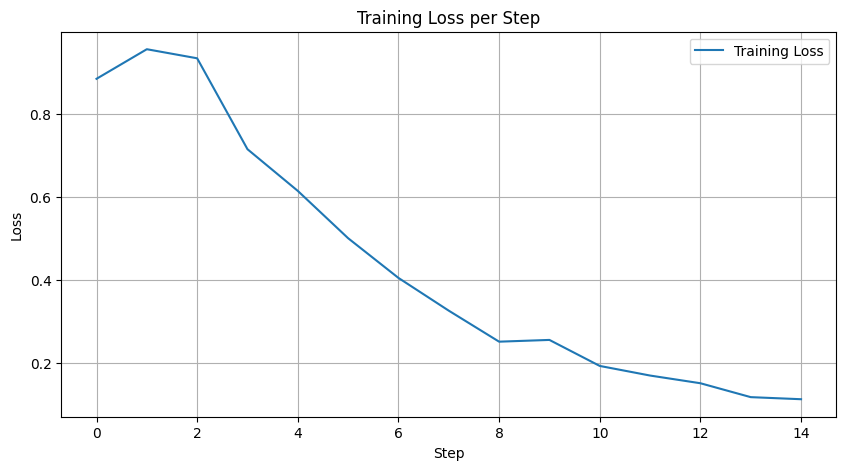

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


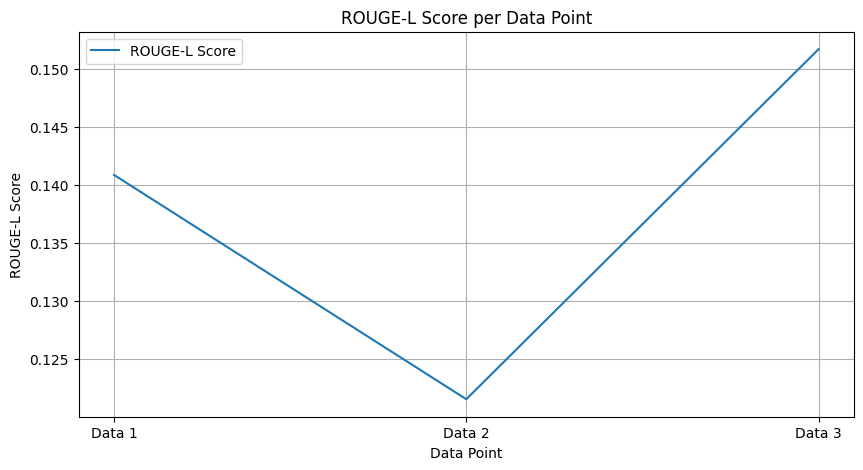

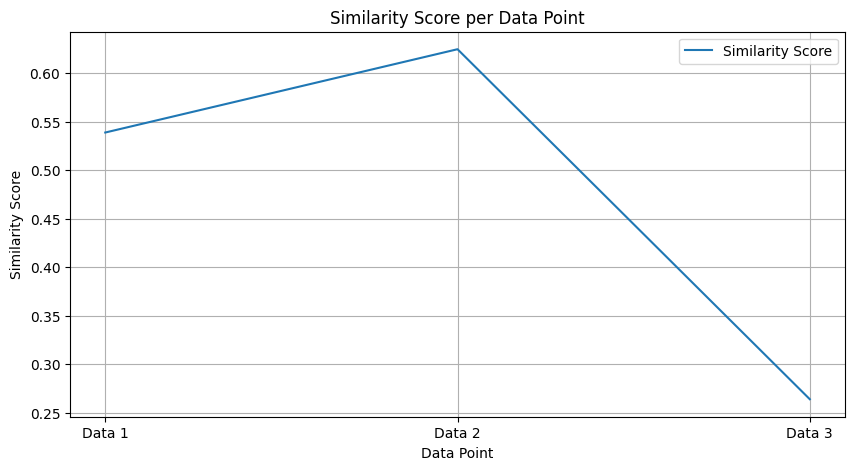

In [3]:
main()

In [ ]:
!nvidia-smi

Wed Jun 19 05:59:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0              32W /  70W |   5663MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch
def check_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using GPU:", torch.cuda.get_device_name(0))
    else:
        device = torch.device("cpu")
        print("Using CPU")
    return device

check_device()

Using GPU: Tesla T4


device(type='cuda')

In [ ]:
# import torch

# def save_model(model, model_path="model.pth"):
#     torch.save(model.state_dict(), model_path)

# # Call this function at the end of your training
# save_model(model)

NameError: name 'mlflow' is not defined

In [ ]:
import torch
print(torch.__version__)
